# Variational Autoencoders

[Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013)](https://arxiv.org/abs/1312.6114)

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim

from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torchvision import datasets, transforms

from tqdm import tqdm

%matplotlib inline

## Configuration and Hyperparameters

In [2]:
batch_size = 16
noise_size = 100
hidden_size = 128
learning_rate = 1e-3
plot_size = 10
epochs = 10

## Load the dataset

In [3]:
use_cuda = torch.cuda.is_available()

In [4]:
mnist = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist/raw/',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [5]:
image_height = mnist.dataset.train_data.shape[1]
image_width = mnist.dataset.train_data.shape[2]
image_size = image_height * image_width
print("Number of features:", image_size)

Number of features: 784


## Models

In [6]:
def initialize_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

In [7]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.hidden = nn.Linear(image_size, hidden_size)
        self.activation = nn.ReLU()
        
        self.hidden_to_mu = nn.Linear(hidden_size, noise_size)
        self.hidden_to_logvar = nn.Linear(hidden_size, noise_size)

    def forward(self, inputs):
        outputs = self.activation(self.hidden(inputs))
        mu = self.hidden_to_mu(outputs)
        logvar = self.hidden_to_logvar(outputs)
        return mu, logvar

In [8]:
class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(noise_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.layers(inputs)

## Train the networks

In [9]:
encoder = Encoder()
decoder = Decoder()

encoder.apply(initialize_weights)
decoder.apply(initialize_weights)

parameters = list(encoder.parameters()) + list(decoder.parameters())

optimization = optim.Adam(parameters, lr=learning_rate)

In [10]:
def generate_noise(size):
    return torch.randn(size, noise_size)

In [11]:
def reparametrization(mu, logvar):
    noise = Variable(generate_noise(batch_size))
    if use_cuda:
        noise = noise.cuda()
    return mu + torch.exp(logvar / 2) * noise

In [12]:
def generate_images(size):
    with torch.no_grad():
        noise = Variable(generate_noise(size))
        if use_cuda:
            noise = noise.cuda()
        images = decoder(noise)
    return images.data

In [13]:
def plot_images(images):
    fig = plt.figure(figsize=(len(images), 1))
    gs = gridspec.GridSpec(1, len(images))
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, image in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(image.reshape(image_width, image_height),
                   cmap='Greys_r',
                   interpolation='None')
        
    plt.show()

In [14]:
if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

In [15]:
def loss_function(reconstructed, images, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(reconstructed,
                                                 images,
                                                 reduction="sum")
    reconstruction_loss = reconstruction_loss / batch_size
    
    kld_loss = torch.sum(torch.exp(logvar) + mu ** 2 - 1. - logvar, 1)
    kld_loss = torch.mean(0.5 * kld_loss)
    
    return reconstruction_loss + kld_loss

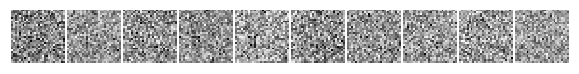

Epoch 1/10: 100%|██████████| 3750/3750 [03:59<00:00, 15.69it/s, loss=127.189]


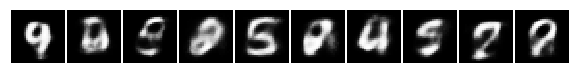

Epoch 2/10: 100%|██████████| 3750/3750 [04:00<00:00, 15.60it/s, loss=112.392]


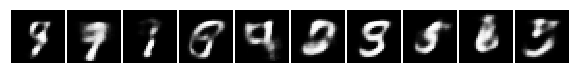

Epoch 3/10: 100%|██████████| 3750/3750 [04:11<00:00, 16.11it/s, loss=117.846]


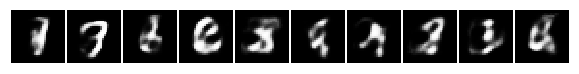

Epoch 4/10: 100%|██████████| 3750/3750 [04:17<00:00, 14.55it/s, loss=108.723]


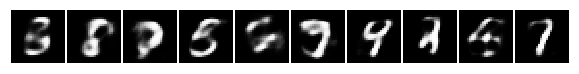

Epoch 5/10: 100%|██████████| 3750/3750 [04:05<00:00, 15.30it/s, loss=115.179]


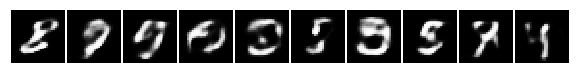

Epoch 6/10: 100%|██████████| 3750/3750 [04:28<00:00, 13.94it/s, loss=113.961]


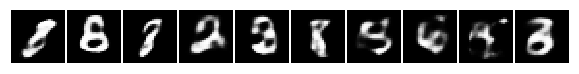

Epoch 7/10: 100%|██████████| 3750/3750 [04:11<00:00, 14.89it/s, loss=122.539]


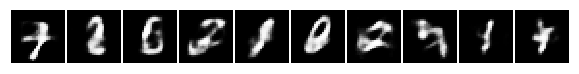

Epoch 8/10: 100%|██████████| 3750/3750 [04:18<00:00, 18.20it/s, loss=99.609] 


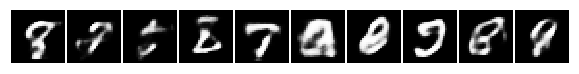

Epoch 9/10: 100%|██████████| 3750/3750 [04:21<00:00, 16.02it/s, loss=121.034]


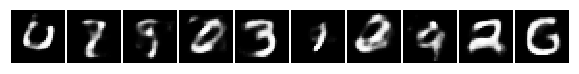

Epoch 10/10: 100%|██████████| 3750/3750 [04:08<00:00, 15.93it/s, loss=108.367]


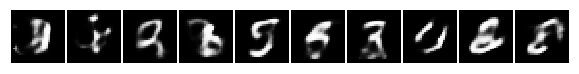

In [16]:
plot_images(generate_images(plot_size))

for epoch in range(epochs):
    with tqdm(total=len(mnist)) as progress_bar:
        progress_bar.set_description("Epoch {:d}/{:d}".format(epoch + 1, epochs))
        for iteration, (images, _) in enumerate(mnist):
            optimization.zero_grad()

            images = Variable(images).view(-1, image_size)
            if use_cuda:
                images = images.cuda()

            mu, logvar = encoder(images)
            code = reparametrization(mu, logvar)
            reconstructed = decoder(code)

            loss = loss_function(reconstructed, images, mu, logvar)

            loss.backward()
            optimization.step()

            if use_cuda:
                loss = loss.cpu()

            progress_bar.set_postfix(loss="{:.03f}".format(loss.data.item()))
            progress_bar.update()
            
    plot_images(generate_images(plot_size))